# Additional - Kinked beam

![](https://raw.githubusercontent.com/ibcmrocha/public/main/newforce.png)

With:
- $l_1 = 4$
- $l_2 = 5$
- $l_3 = 3$
- $EI = 5000$
- $EA = 15000$
- $q = 6$
- $F = 40$

Solve this problem.

In [1]:
import numpy as np
import matplotlib as plt
import matrixmethod as mm
%config InlineBackend.figure_formats = ['svg']

%reload_ext autoreload
%autoreload 2

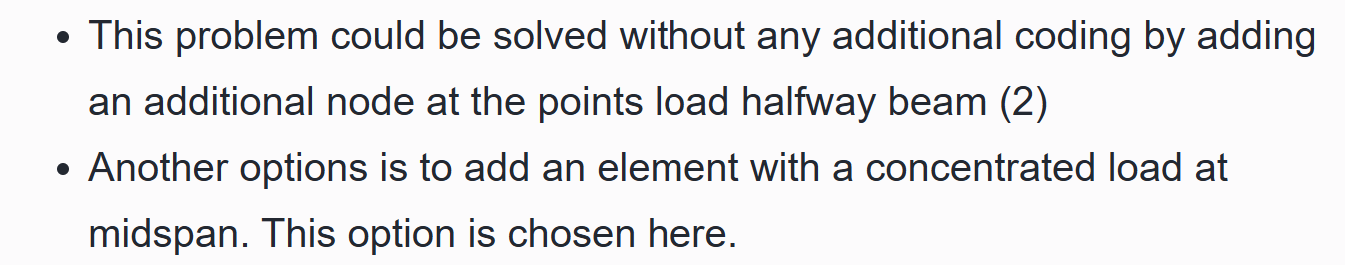

In [2]:
import sympy as sym
sym.init_printing()

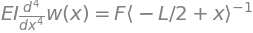

In [3]:
EI, F, x = sym.symbols('EI, F, x')
L = sym.symbols('L',positive=True)
w = sym.Function('w')

ODE_bending = sym.Eq(w(x).diff(x, 4) *EI, F*sym.SingularityFunction(x, L/2, -1))
display(ODE_bending)

- SingularityFunction(x, L/2, -1) represents the point force $𝐹$ applied at $𝑥=𝐿/2$ with a magnitude of −1, −1 indicating a downward force. 
- The SingularityFunction is a way to mathematically express a point load in beam bending equations.

In [4]:
V = - sym.integrate(ODE_bending.rhs, x) + sym.symbols('C1')
M = sym.integrate(V, x) + sym.symbols('C2')
kappa = M / EI
phi = sym.integrate(kappa, x) + sym.symbols('C3')
w = -sym.integrate(phi, x) + sym.symbols('C4')
display(w)

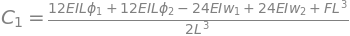

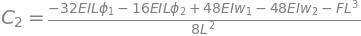

In [5]:
w_1, w_2, phi_1, phi_2 = sym.symbols('w_1, w_2, phi_1, phi_2')
phi = -w.diff(x)
eq1 = sym.Eq(w.subs(x,0),w_1)
eq2 = sym.Eq(w.subs(x,L),w_2)
eq3 = sym.Eq(phi.subs(x,0),phi_1)
eq4 = sym.Eq(phi.subs(x,L),phi_2)
C_sol = sym.solve([eq1, eq2, eq3, eq4 ], sym.symbols('C1, C2, C3, C4'))
for key in C_sol:
    display(sym.Eq(key, C_sol[key]))

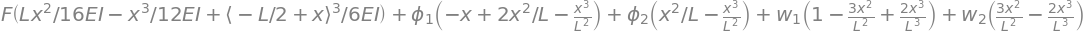

In [6]:
display(sym.collect(M.subs(C_sol).expand(),[w_1,w_2,phi_1,phi_2, F]))
display(sym.collect(w.subs(C_sol).expand(),[w_1,w_2,phi_1,phi_2, F]))

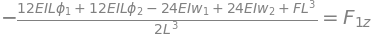

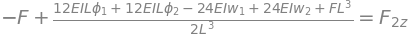

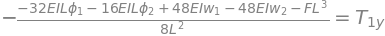

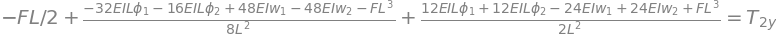

In [7]:
F_1_z, F_2_z, T_1_y, T_2_y = sym.symbols('F_1_z, F_2_z, T_1_y, T_2_y')

eq5 = sym.Eq(-V.subs(C_sol).subs(x,0), F_1_z)
eq6 = sym.Eq(V.subs(C_sol).subs(x,L), F_2_z)
eq7 = sym.Eq(-M.subs(C_sol).subs(x,0), T_1_y)
eq8 = sym.Eq(M.subs(C_sol).subs(x,L), T_2_y)
display(eq5, eq6, eq7, eq8)

In [8]:
A, b = sym.linear_eq_to_matrix([eq5,eq7, eq6, eq8], [w_1, phi_1, w_2, phi_2])
display(A,b)

⎡ 12⋅EI   -6⋅EI   -12⋅EI   -6⋅EI ⎤
⎢ ─────   ──────  ───────  ──────⎥
⎢   3        2       3        2  ⎥
⎢  L        L       L        L   ⎥
⎢                                ⎥
⎢-6⋅EI     4⋅EI    6⋅EI     2⋅EI ⎥
⎢──────    ────    ────     ──── ⎥
⎢   2       L        2       L   ⎥
⎢  L                L            ⎥
⎢                                ⎥
⎢-12⋅EI    6⋅EI    12⋅EI    6⋅EI ⎥
⎢───────   ────    ─────    ──── ⎥
⎢   3        2       3        2  ⎥
⎢  L        L       L        L   ⎥
⎢                                ⎥
⎢-6⋅EI     2⋅EI    6⋅EI     4⋅EI ⎥
⎢──────    ────    ────     ──── ⎥
⎢   2       L        2       L   ⎥
⎣  L                L            ⎦

⎡  F          ⎤
⎢  ─ + F_1_z  ⎥
⎢  2          ⎥
⎢             ⎥
⎢  F⋅L        ⎥
⎢- ─── + T_1_y⎥
⎢   8         ⎥
⎢             ⎥
⎢  F          ⎥
⎢  ─ + F_2_z  ⎥
⎢  2          ⎥
⎢             ⎥
⎢ F⋅L         ⎥
⎢ ─── + T_2_y ⎥
⎣  8          ⎦

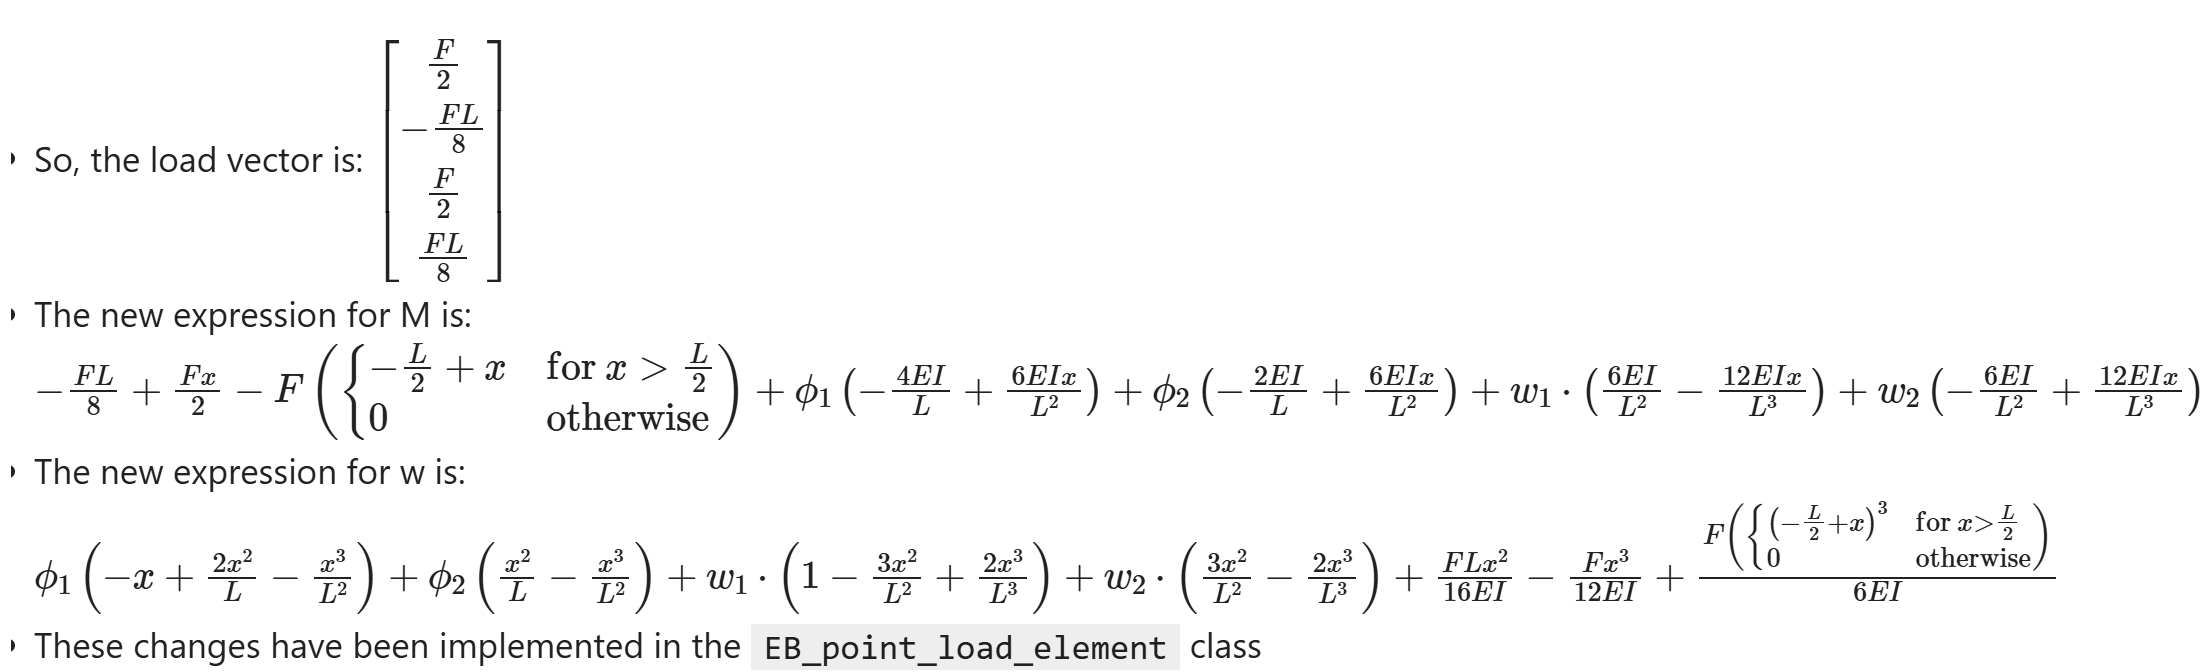

In [9]:
L1 = 4
L2 = 5
L3 = 3
EI = 5000
EA = 15000
q = 6
F = 40

mm.Node.clear()
mm.Element.clear()

nodes = []
nodes.append(mm.Node(0,0))
nodes.append(mm.Node(L1,-L3))
nodes.append(mm.Node(L1+L2,-L3))

elems = []
elems.append(mm.Element(nodes[0], nodes[1]))
elems.append(mm.EB_point_load_element(nodes[1], nodes[2])) # special

section = {}
section['EI'] = EI
section['EA'] = EA

for elem in elems:
    elem.set_section(section)
    print(elem)

elems[0].add_distributed_load([0,q])
elems[1].add_point_load_halfway(F)

con = mm.Constrainer()

con.fix_node(nodes[0])
con.fix_dof(nodes[2], 0)
con.fix_dof(nodes[2], 1)

nodes[1].add_load([0,F,0])

print(con)
for elem in elems:
    print(elem)

global_k = np.zeros ((3*len(nodes), 3*len(nodes)))
global_f = np.zeros (3*len(nodes))

for e in elems:
    elmat = e.stiffness()
    idofs = e.global_dofs()
    
    global_k[np.ix_(idofs,idofs)] += elmat

for n in nodes:
    global_f[n.dofs] += n.p

Kff, Ff = con.constrain ( global_k, global_f )
u = np.matmul ( np.linalg.inv(Kff), Ff )
print(u)

print(con.support_reactions(global_k,u,global_f))






AttributeError: module 'matrixmethod' has no attribute 'EB_point_load_element'